<a href="https://colab.research.google.com/github/JeLaKo/apple-tree-disease/blob/main/Milestone3_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the data directly through Kaggle's API

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# !pip install -U -q kaggle==1.5.8

In [2]:
%cd /content/gdrive/MyDrive/MLP/

/content/gdrive/MyDrive/MLP


In [3]:
import os

In [ ]:
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/MLP/"
# ! kaggle competitions download -c plant-pathology-2021-fgvc8

In [ ]:
# ! unzip -q plant-pathology-2021-fgvc8.zip -d train

Data processing


In [4]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

%cd /content/gdrive/MyDrive/MLP/train/

/content/gdrive/MyDrive/MLP/train


In [5]:
# import mlxtend package for confusion matrix
import mlxtend
                                                          
print(mlxtend.__version__) 

! pip install mlxtend --upgrade --no-deps

print(mlxtend.__version__) 

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


0.19.0
0.19.0


In [6]:
df = pd.read_csv('train.csv')

In [7]:
new_labels = df['labels'].to_list()

for i in range(len(new_labels)):
  if new_labels[i] == 'scab frog_eye_leaf_spot complex' or new_labels[i] == 'scab frog_eye_leaf_spot':
    new_labels[i] = 'scab'
  elif new_labels[i] == 'frog_eye_leaf_spot complex':
    new_labels[i] = 'frog_eye_leaf_spot'
  elif new_labels[i] == 'powdery_mildew complex':
    new_labels[i] = 'powdery_mildew'
  elif new_labels[i] == 'rust complex' or new_labels[i] == 'rust frog_eye_leaf_spot':
    new_labels[i] = 'rust'


In [8]:
df['adjusted labels'] = np.array(new_labels)
df = df.drop('labels', axis = 1)


In [9]:
def sample(df, sample_size):
  """
  This function gets an equal sample inclusive of all classes from the input dataframe
  """
  df_sampled = []
  classes = df['adjusted labels'].unique()

  for i in classes:
      g = df[df['adjusted labels'] == i].sample(sample_size)
      df_sampled.append(g)

  df_sampled = pd.concat(df_sampled)
  return df_sampled

df_sampled = sample(df, 1184)
print(df_sampled)

                      image adjusted labels
2845   95ec69d324a95aac.jpg         healthy
3850   a0304ff9fc1f4b60.jpg         healthy
5932   abbbe05b1028dcdc.jpg         healthy
8384   bc2482f08df32dcb.jpg         healthy
14557  e5d91756a2aa5a45.jpg         healthy
...                     ...             ...
3406   9b9832ecbd60702f.jpg  powdery_mildew
1334   89f63639b00fdb03.jpg  powdery_mildew
4996   a6e6c6742e14e19d.jpg  powdery_mildew
13698  e062c0b63cd36f1b.jpg  powdery_mildew
2919   96943ee158c32e3e.jpg  powdery_mildew

[7104 rows x 2 columns]


In [10]:
def one_hot(df):
  """
  This function returns all classes and combination of classes found in the input-dataframe, and returns
  the one-hot encoded version
  """
  one_hot = pd.get_dummies(df['adjusted labels'])
  df = df.drop('adjusted labels', axis = 1)
  df = df.join(one_hot)
  return df

df_onehot = one_hot(df_sampled)


In [44]:
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, preprocessing

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

    # optimizer = keras.optimizers.Adam(lr = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

In [12]:
# convert dictionary into a hashable type
df_dict = df_onehot.set_index('image').T.to_dict('list')

# gather names of all images in the image-directory
train_images = os.listdir('train_images/')

# find corresponding key to image from directory
# resized the image and add that to a different directory for later use
for image in df_dict.keys():
  if image in train_images:
    img = cv2.imread('train_images/' + image)
    resized_img = cv2.resize(img, (96, 96)) 
    cv2.imwrite('resized_train_images/' + image, resized_img)

labels = list(df_dict.values())

In [ ]:
# find corresponding image from the resized directory and add that to a list
images = []
for image in df_dict.keys():
  if image in train_images:
    img_resized = cv2.imread('resized_train_images/' + image) 
    images.append(img_resized)

In [13]:
images = np.array(images)
labels = np.array(labels)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.3, random_state=42)

Epoch 1/80
156/156 [==============================] - 21s 129ms/step - loss: 2.3285 - accuracy: 0.2228 - val_loss: 1.7149 - val_accuracy: 0.2308
Epoch 2/80
156/156 [==============================] - 20s 128ms/step - loss: 1.9333 - accuracy: 0.2494 - val_loss: 1.7718 - val_accuracy: 0.2345
Epoch 3/80
156/156 [==============================] - 19s 124ms/step - loss: 1.8444 - accuracy: 0.2603 - val_loss: 1.6709 - val_accuracy: 0.2875
Epoch 4/80
156/156 [==============================] - 20s 126ms/step - loss: 1.7894 - accuracy: 0.2651 - val_loss: 1.9391 - val_accuracy: 0.2533
Epoch 5/80
156/156 [==============================] - 20s 125ms/step - loss: 1.7330 - accuracy: 0.2892 - val_loss: 1.7242 - val_accuracy: 0.2528
Epoch 6/80
156/156 [==============================] - 19s 123ms/step - loss: 1.6873 - accuracy: 0.3113 - val_loss: 1.7971 - val_accuracy: 0.2641
Epoch 7/80
156/156 [==============================] - 20s 128ms/step - loss: 1.6347 - accuracy: 0.3262 - val_loss: 1.7306 - val_ac

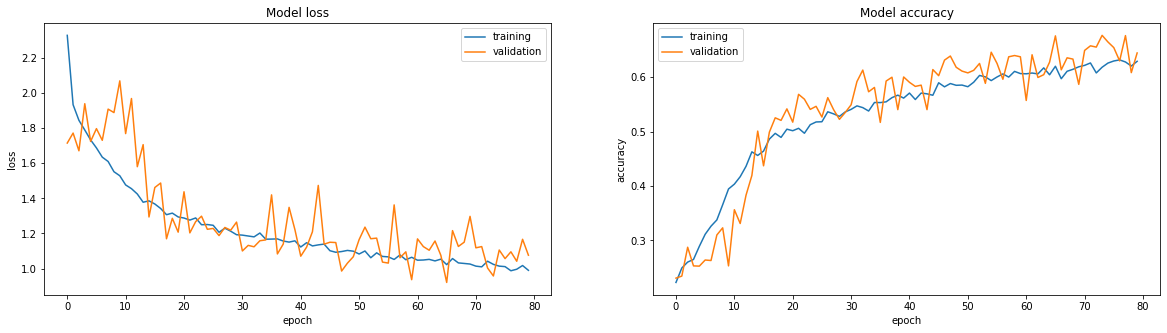

67/67 [==============================] - 1s 15ms/step - loss: 1.0761 - accuracy: 0.6445
Validation Accuracy: 0.6444652676582336


In [48]:
# ML MODEL ARCHITECTURE
# Define Sequential model
model = models.Sequential()

# create convolutional layer and max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# create convolutional layer (larger) and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# add Conv2D layer with 128 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# add Conv2D layer with 256 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add Conv2D layer with 32 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten layers
model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.5)))

# apply softmax activation for final layer classification
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))

# normalize input data: set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# augment data: set augmentation dictionary
augment = {'horizontal_flip': True, 
           'vertical_flip': True, 
           'rotation_range': 20, 
           'width_shift_range': 0.1, 
           'height_shift_range': 0.1, 
           'zoom_range': [0.3,1.0], 
           'brightness_range': [0.2,1.2],
           'channel_shift_range' : 0.7}

# run training and evaluation function
train_and_evaluate(model, x_train, y_train, x_val, y_val, preprocess, epochs = 80, augment = augment)


In [49]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 24, 24, 64)      

array(['healthy', 'scab', 'complex', 'rust', 'frog_eye_leaf_spot',
       'powdery_mildew'], dtype=object)

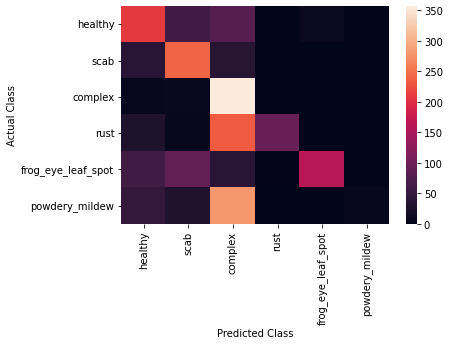

tf.Tensor(
[[210  62  80   0  11   0]
 [ 39 241  37   0   1   0]
 [  6   7 357   0   0   0]
 [ 28   6 234  95   0   0]
 [ 61  90  39   2 161   0]
 [ 48  30 279   1   1   6]], shape=(6, 6), dtype=int32)


In [50]:
import seaborn as sns
import tensorflow as tf
from tensorflow import math as tfmath

classes = df['adjusted labels'].unique()
display(classes)

y_true = tf.argmax(y_val, axis=1)

y_pred = model.predict(x_val)
# y_pred = tf.keras.utils.to_categorical(y_pred, num_classes = 6)
y_pred = tf.argmax(y_pred, axis = 1)

conf_matrix = tfmath.confusion_matrix(y_true, y_pred, num_classes=6)

ax = sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

print(conf_matrix)

In [ ]:
! pip install mlxtend

array(['healthy', 'scab', 'complex', 'rust', 'frog_eye_leaf_spot',
       'powdery_mildew'], dtype=object)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f63ad313a10>)

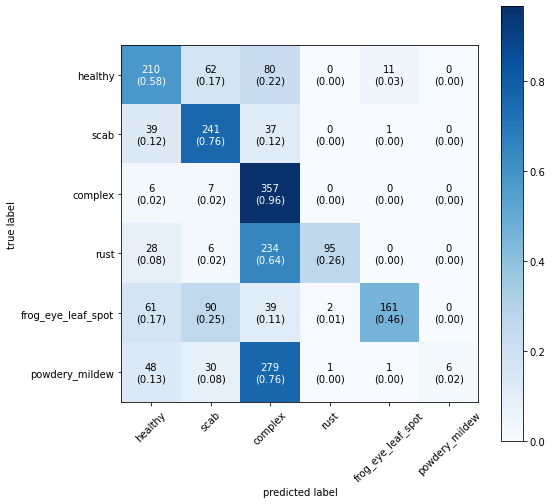

In [51]:

# set labels for confusion matrix
labels =  df['adjusted labels'].unique()
display(labels)

# create and plot matrix
mtrx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat = mtrx, figsize=(8, 8), class_names=labels, colorbar=True, show_normed = True) # class_names=labels,